# Contrast single spot animation with `starry`

In this workbook we will make a wavelength-dependent spot contrast animation.

In [1]:
import starry
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

/Users/obsidian/anaconda3/envs/starry_base/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


## Set the spot size

In [2]:
sigma=0.005

### Figure out the conversion from input amplitude & sigma, to spot depth.

In [3]:
map0 = starry.Map(lmax=33)
map0[0,0] = 1

In [4]:
map1 = starry.Map(lmax=33)
map1[0,0] = 1
amp=0.01
map1.add_spot(-1.0*amp, sigma, 0, 0)

Define an experimentally-determined normalization constant for each sigma:

$$k(\sigma) = \frac{I_\star(0,0) - I_{\circ, \sigma}(0,0)}{A_{in}}$$

where $\star$ and $\circ$ denote the fiducial star and spot fluxes evaluated at the center of the disk, and $A_{in}$ is the input amplitude.


In [5]:
spot_free = map0(x=0, y=0)

In [6]:
k_sig_0p01 = (map0(x=0, y=0) - map1(x=0, y=0)) / amp
k_sig_0p01

30.850724233612137

In [7]:
xs = np.arange(-1, 1, 0.01)

In [8]:
map1 = starry.Map(lmax=33)
map1[0,0] = 1
amp=0.01
map1.add_spot(-1.0*amp, sigma, 0, 0)
ys = map1(x=xs, y=0)

(-0.1, 0.3501408748021699)

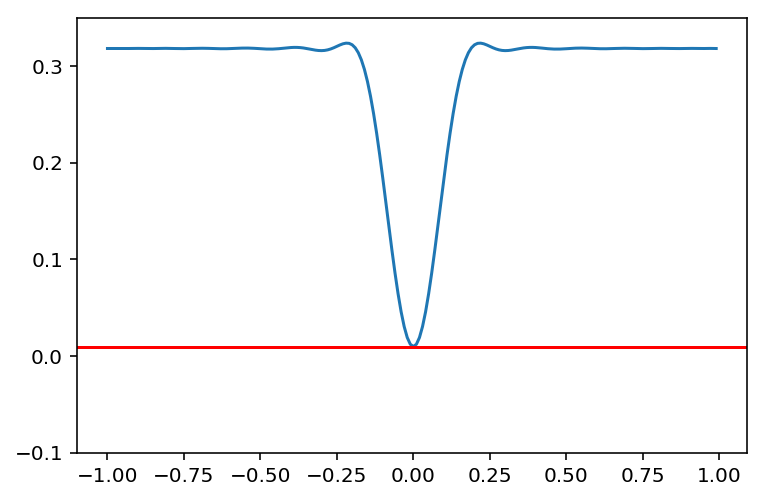

In [9]:
plt.plot(xs, ys)
plt.axhline(map0(x=0, y=0)-k_sig_0p01*amp, color='r')
plt.ylim(-0.1, map0(x=0, y=0)*1.1)

To get contrast you need:

$$c = \frac{I_\star - k(\sigma) \cdot A_{in}}{I_\star}$$
or:
$$A_{in} = \frac{I_\star (1-c)}{k(\sigma)}$$

In [10]:
def amp_to_contast(amp):
    '''convert spot contrast to amp for starry'''
    contast = (spot_free - k_sig_0p01 * amp)/spot_free
    return contast

In [11]:
@np.vectorize
def contast_to_amp(contrast):
    '''convert spot contrast to amp for starry'''
    A_in = (spot_free * (1-contrast))/k_sig_0p01
    return A_in

In [12]:
contast_to_amp(0.0)

array(0.01031774)

Yay!  We have a contrast to amplitude converter!

In [13]:
map1[0,0] + amp/4

1.0

### Spot contrast versus wavelength

#### Get the Kepler band

In [14]:
kep_response = pd.read_csv('../../xveganx/data/K2/kepler_response_hires1.txt',
                           names=['wl_nm','trans'],
                           skiprows=9, delim_whitespace=True)
kep_response['wl_ang'] = kep_response.wl_nm * 10.0
kep_response = kep_response[(kep_response.wl_ang > 4200) & (kep_response.wl_ang < 9200)]
kep_response['trans_norm'] = kep_response.trans / np.sum(kep_response.trans)
kep_response = kep_response.reset_index(drop=True)

In [15]:
kep_response.head()

,wl_nm,trans,wl_ang,trans_norm
0,421,0.01821,4210.0,0.000071
1,422,0.02507,4220.0,0.000098
2,423,0.03332,4230.0,0.000130
3,424,0.04333,4240.0,0.000169
4,425,0.05630,4250.0,0.000220


#### Get the TESS bandpass

In [16]:
#! wget https://heasarc.gsfc.nasa.gov/docs/tess/data/tess-response-function-v1.0.csv

In [17]:
tess_response = pd.read_csv('../data/tess-response-function-v1.0.csv', skiprows=8, names=['wl_nm', 'trans'])

TODO: make a normalized version, so the area under the curve is one.

In [18]:
import astropy.modeling
import astropy.units as u

In [19]:
bb_lam = astropy.modeling.blackbody.blackbody_lambda

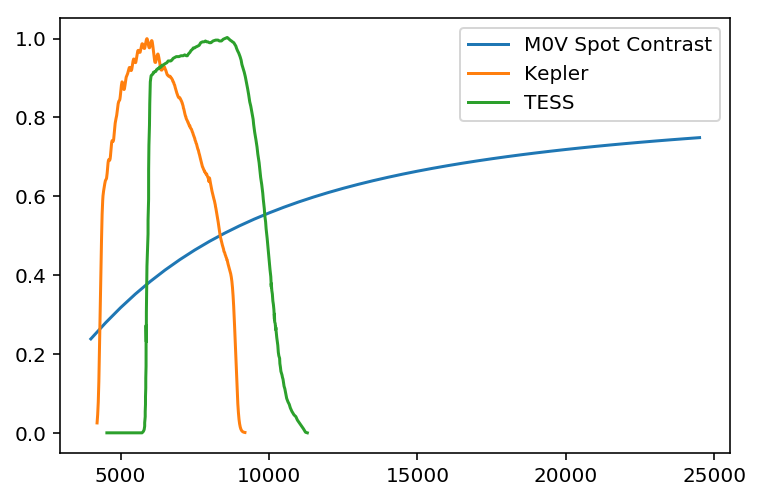

In [20]:
#wls = np.array([4000, 10000, 25000])
wls = np.arange(4000, 25000, 500)
T_phot = 3800.0
T_spot = 3300.0#0.86 * T_phot
flux_hot = bb_lam(wls*u.angstrom, T_phot)
flux_cool = bb_lam(wls*u.angstrom, T_spot)

contrast = flux_cool/flux_hot

plt.plot(wls, contrast, label='M0V Spot Contrast')
plt.plot(kep_response.wl_ang, kep_response.trans_norm / kep_response.trans_norm.max(), label='Kepler')
plt.plot(tess_response.wl_nm*10.0, tess_response.trans, label='TESS')
plt.legend(loc='best')

In [21]:
import Starfish

/Users/obsidian/GitHub/Starfish/Starfish/__init__.py:16: UserWarning: Using the default config.yaml file located at /Users/obsidian/GitHub/Starfish/Starfish/config.yaml. This is likely NOT what you want. Please create a similar 'config.yaml' file in your current working directory.
  warnings.warn("Using the default config.yaml file located at {0}. This is likely NOT what you want. Please create a similar 'config.yaml' file in your current working directory.".format(default), UserWarning)


In [22]:
import yaml

In [23]:
with open('../../xveganx/sf/BVRIJHK_demo/demo1/config.yaml') as fn:
    text = yaml.load(fn)

In [24]:
from Starfish.grid_tools import HDF5Interface
import numpy as np
myHDF5 = HDF5Interface(filename='$xveganx/sf/BVRIJHK_demo/demo1/libraries/PHOENIX_Kepler_Teff2700-4500.hdf5')
pflux = myHDF5.load_flux(np.array([T_phot, 3.5, 0.0]))
pflux_cool = myHDF5.load_flux(np.array([T_spot, 3.5, 0.0]))

In [25]:
pflux2 = myHDF5.load_flux(np.array([4500, 3.5, 0.0]))
pflux_cool2 = myHDF5.load_flux(np.array([2700, 3.5, 0.0]))

(0, 1.3)

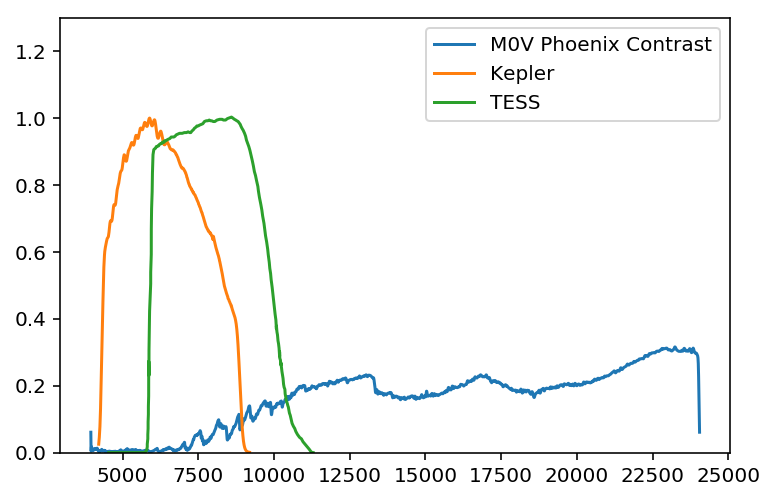

In [26]:
contrast_phoenix = pflux_cool2/pflux2

#plt.plot(wls, contrast, label='M0V BB Contrast')
plt.plot(myHDF5.wl, contrast_phoenix, label='M0V Phoenix Contrast')
plt.plot(kep_response.wl_ang, kep_response.trans_norm / kep_response.trans_norm.max(), label='Kepler')
plt.plot(tess_response.wl_nm*10.0, tess_response.trans, label='TESS')
plt.legend(loc='upper right')

plt.ylim(0,1.3)

In [27]:
wls_in = myHDF5.wl#[800:1000]
contrast = contrast_phoenix#[800:1000]

In [28]:
#amps_in = contast_to_amp(contrast.value)
amps_in = contast_to_amp(contrast)

In [29]:
nw, = amps_in.shape
nw

4096

In [30]:
amps_in.dtype = np.float64

In [31]:
sigma

0.005

In [32]:
map2 = starry.Map(lmax=33, nw=len(amps_in))
map2[0,0] = 1
#map2[1] = 0.4
#map2[2] = 0.26

map2.axis = [1, 0, 0]

n_spots = 28
drot = 355/n_spots
df = pd.read_csv('spot_locs_n28.csv')

for j in range(n_spots):
    map2.axis=[1,0,0]
    lat = np.float(df.lats_N[j])
    map2.rotate(lat)
    map2.add_spot(-1.0*amps_in, sigma, lat=0, lon=0, lmax=31)
    map2.rotate(-1.0*lat)
    
    lat = np.float(df.lats_S[j])
    map2.rotate(lat)
    map2.add_spot(-1.0*amps_in, sigma, lat=0, lon=0, lmax=31)
    map2.rotate(-1.0*lat)
    
    map2.axis=[0,1,0]
    map2.rotate(drot+df.long_jitter[j])

In [72]:
%%time
thetas = np.arange(0, 360*1, 2.0)

CPU times: user 19 µs, sys: 3 µs, total: 22 µs
Wall time: 25.7 µs


In [73]:
%%time
fluxes = map2.flux(theta=thetas)

CPU times: user 17.9 s, sys: 168 ms, total: 18.1 s
Wall time: 18.1 s


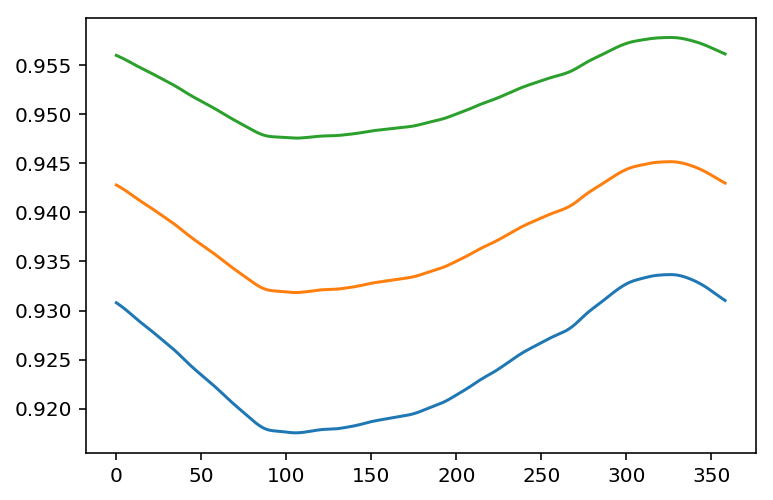

In [74]:
plt.plot(thetas, fluxes[:, 0])
plt.plot(thetas, fluxes[:, 2000]), 
plt.plot(thetas, fluxes[:, 4000])

Try an occultation lightcurve.  Let's immitate V1298 Tau.

12 hour observation

In [108]:
obs_duration = 12

In [113]:
stell_angle_subtended = 360.0/(2.851*24)*obs_duration#
stell_angle_subtended

63.135741844966674

In [110]:
times = np.linspace(0, obs_duration, npts)

In [111]:
speed = 2.0 /6.386 # two stellar radii in 6.386 hours

In [112]:
position = -2.0 + speed*times

In [133]:
%%time
npts = 100
ro = 0.1
xo = position
yo = 0.0
theta = np.linspace(0, stell_angle_subtended, npts, endpoint=False)
fluxes2 = map2.flux(theta=theta, xo=xo, yo=yo, ro=ro)

CPU times: user 12.8 s, sys: 262 ms, total: 13.1 s
Wall time: 13 s


(0.9116205622172051, 0.9581006605490281)

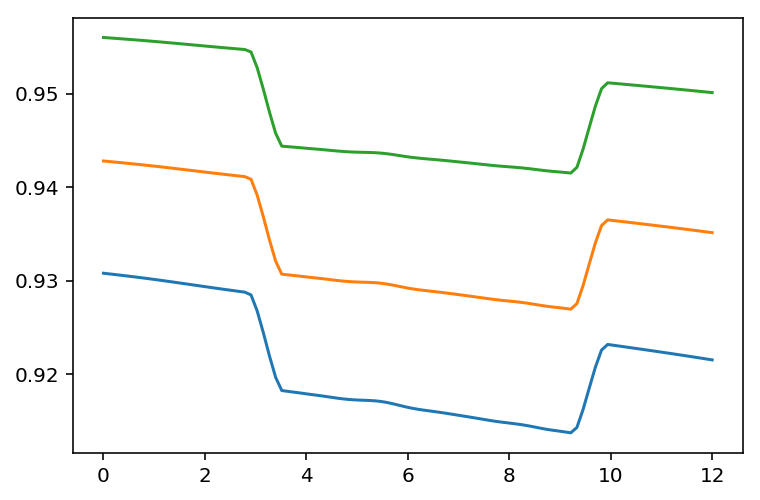

In [134]:
plt.plot(times, fluxes2[:, 0])
plt.plot(times, fluxes2[:, 2000]), 
plt.plot(times, fluxes2[:, 4000])
plt.ylim()

In [135]:
baseline.shape

(4096,)

In [157]:
%%time
fluxes0 = map0.flux(theta=theta, xo=xo, yo=yo, ro=ro)

CPU times: user 168 µs, sys: 933 µs, total: 1.1 ms
Wall time: 2.14 ms


In [158]:
baseline = fluxes2[0,:][:, np.newaxis]-(fluxes2[0, :] - fluxes2[-1, :])[:, np.newaxis]*np.linspace(0, 1, npts)*1.0001

In [186]:
wls_in[1400]

7325.012541081119

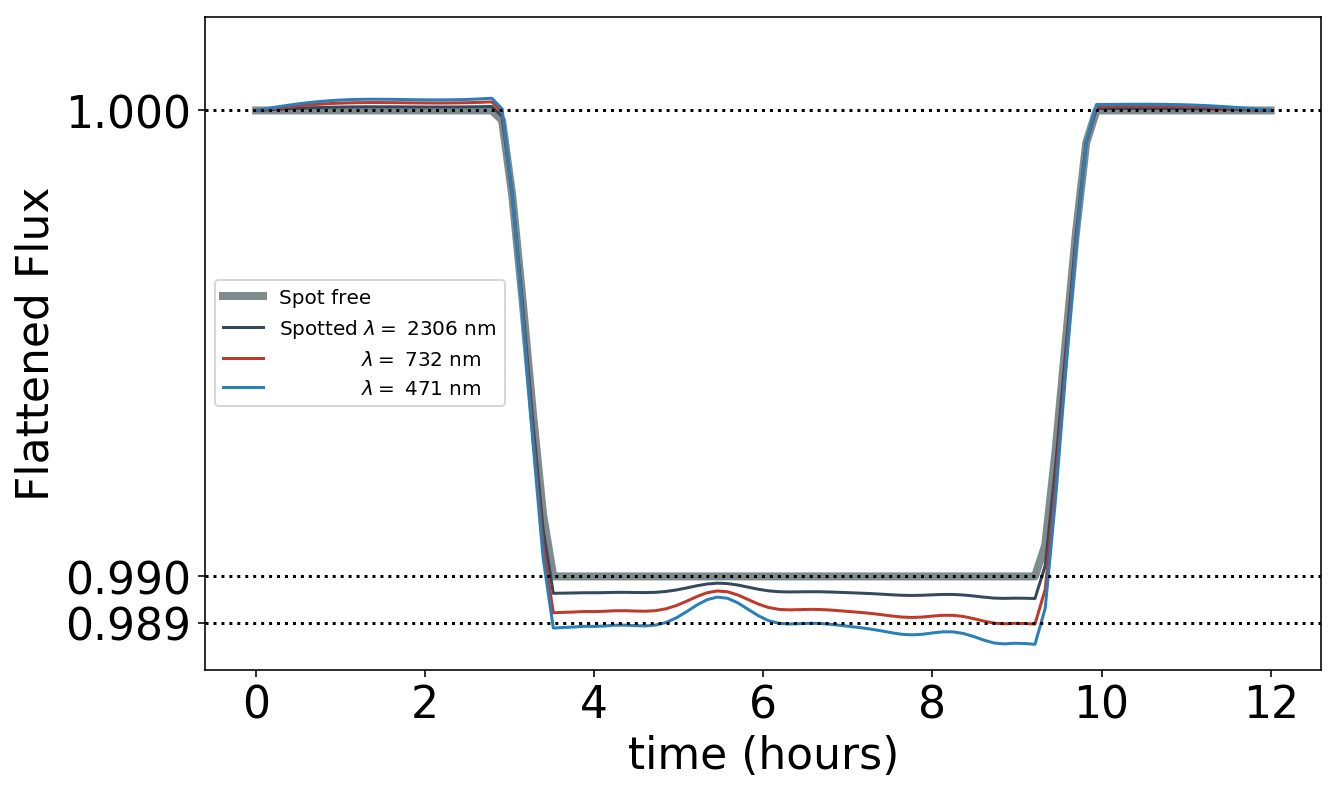

In [194]:
fig, ax = plt.subplots(figsize=(10, 6))
plt.plot(times, fluxes0, lw=4, color='#7f8c8d', label='Spot free')

plt.plot(times, fluxes2[:, 4000]/baseline[4000], color='#34495e',
         label='Spotted $\lambda = $ 2306 nm'), 
plt.plot(times, fluxes2[:, 1400]/baseline[1400], color='#c0392b',
         label='             $\lambda = $ 732 nm'), 
plt.plot(times, fluxes2[:, 400]/baseline[400], color='#2980b9',
         label='             $\lambda = $ 471 nm')

#plt.plot(times, fluxes2/baseline, lw=3, color='#e74c3c', 
#         linestyle='solid', label='Spotted')

plt.axhline(1.0, linestyle='dotted', color='k')
plt.setp(ax.get_xticklabels(), fontsize=22)
plt.setp(ax.get_yticklabels(), fontsize=22)
plt.axhline(1.0-ro**2, linestyle='dotted', color='k')
plt.axhline(0.989, linestyle='dotted', color='k')
plt.xlabel('time (hours)', fontsize=22)
plt.ylabel('Flattened Flux', fontsize=22)
plt.yticks([0.989, 0.99, 1.0])
plt.ylim(0.988, 1.002)
plt.legend(loc='center left')
plt.savefig('TLSE_demo_color.pdf', bbox_inches='tight')


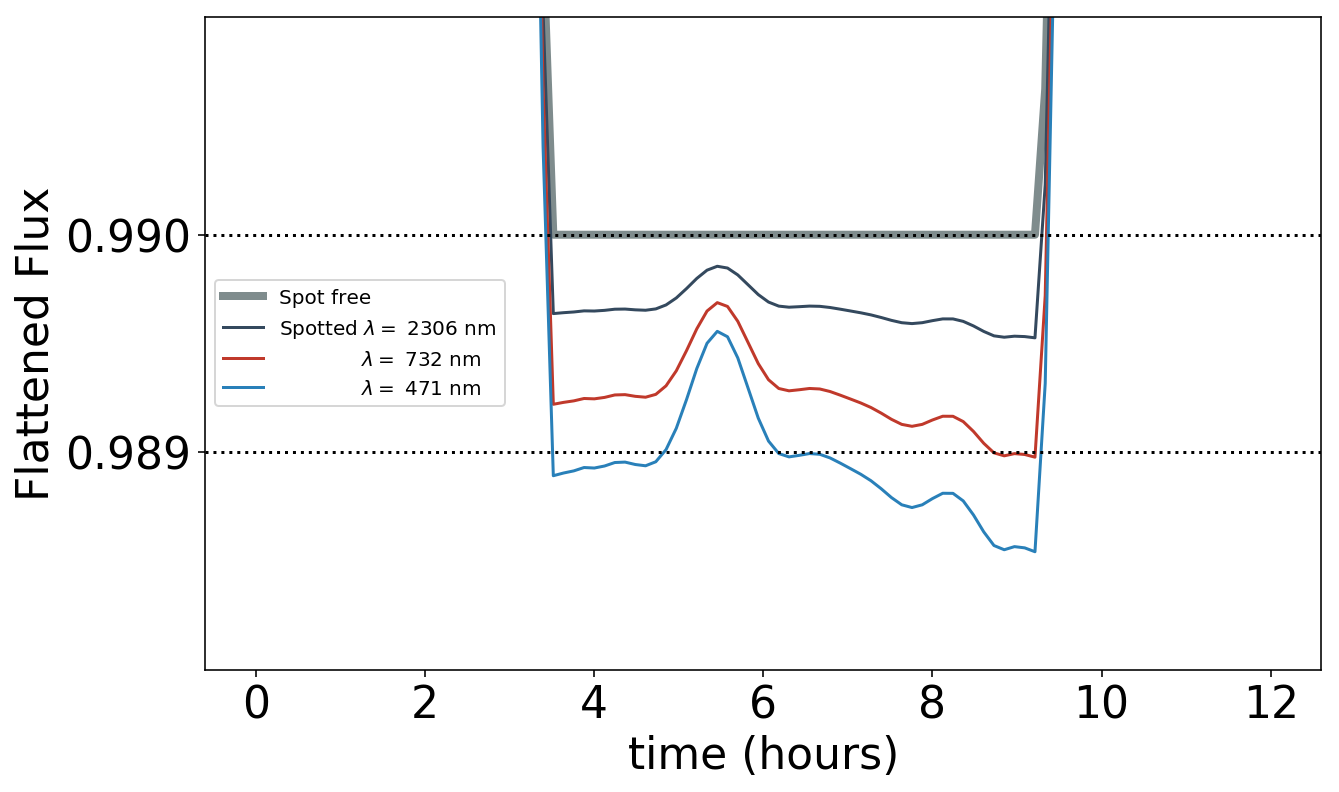

In [192]:
fig, ax = plt.subplots(figsize=(10, 6))
plt.plot(times, fluxes0, lw=4, color='#7f8c8d', label='Spot free')

plt.plot(times, fluxes2[:, 4000]/baseline[4000], color='#34495e',
         label='Spotted $\lambda = $ 2306 nm'), 
plt.plot(times, fluxes2[:, 1400]/baseline[1400], color='#c0392b',
         label='             $\lambda = $ 732 nm'), 
plt.plot(times, fluxes2[:, 400]/baseline[400], color='#2980b9',
         label='             $\lambda = $ 471 nm')

#plt.plot(times, fluxes2/baseline, lw=3, color='#e74c3c', 
#         linestyle='solid', label='Spotted')

plt.axhline(1.0, linestyle='dotted', color='k')
plt.setp(ax.get_xticklabels(), fontsize=22)
plt.setp(ax.get_yticklabels(), fontsize=22)
plt.axhline(1.0-ro**2, linestyle='dotted', color='k')
plt.axhline(0.989, linestyle='dotted', color='k')
plt.xlabel('time (hours)', fontsize=22)
plt.ylabel('Flattened Flux', fontsize=22)
plt.yticks([0.989, 0.99, 1.0])
plt.ylim(0.988, 0.991)
plt.legend(loc='center left')
plt.savefig('TLSE_demo_color_zoom.pdf', bbox_inches='tight')



In [196]:
max_depth2 = 1-np.min(fluxes2/baseline.T, axis=0)

In [197]:
wls_in.shape, max_depth2.shape

((4096,), (4096,))

In [230]:
np.min(max_depth2[:-3])

0.010458969566779386

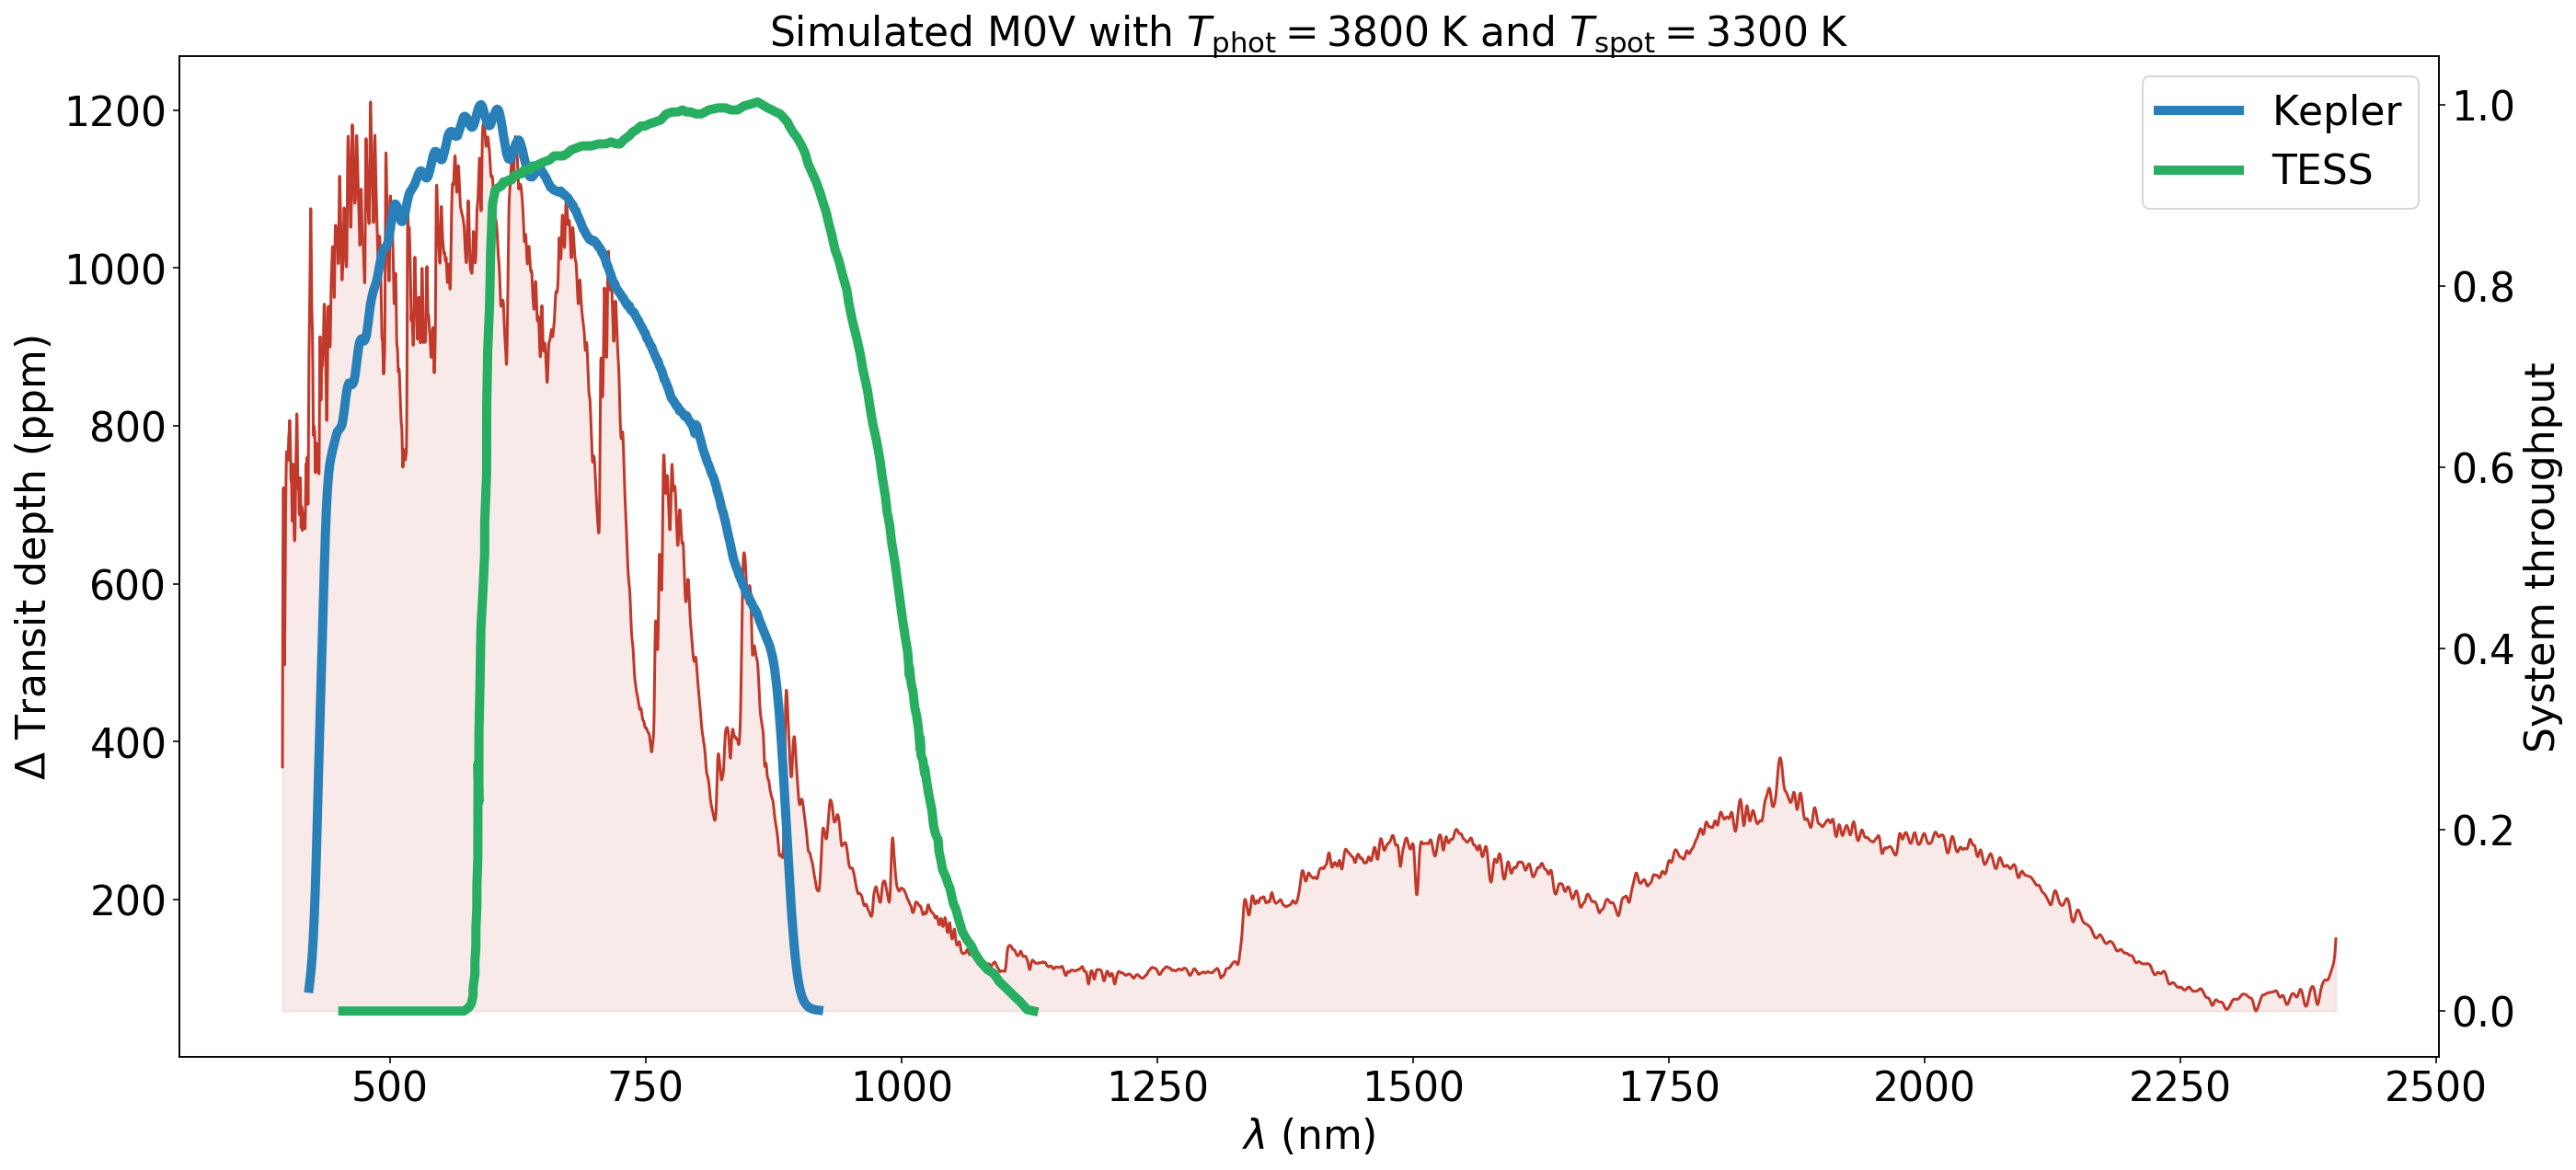

In [231]:
fig, ax = plt.subplots(figsize=(22, 10))

plt.plot(wls_in[:-3]/10.0, max_depth2[:-3], color='#c0392b')
plt.fill_between(wls_in[:-3]/10.0, max_depth2[:-3], np.min(max_depth2[:-3]), color='#c0392b', alpha=0.1)
ax.set_yticklabels([0, 200, 400, 600, 800, 1000, 1200])
plt.setp(ax.get_xticklabels(), fontsize=22)
plt.setp(ax.get_yticklabels(), fontsize=22)
plt.ylabel('$\Delta$ Transit depth (ppm)', fontsize=22)
plt.xlabel('$\lambda$ (nm)', fontsize=22)
plt.title('Simulated M0V with $T_{\mathrm{phot}}=3800\;$K and $T_{\mathrm{spot}}=3300\;$K', fontsize=22)


ax2 = ax.twinx()
plt.plot(kep_response.wl_ang/10, kep_response.trans_norm / kep_response.trans_norm.max(), label='Kepler', color='#2980b9', lw=5)
plt.plot(tess_response.wl_nm, tess_response.trans, label='TESS', color='#27ae60', lw=5)
ax2.set_ylabel('System throughput', fontsize=22)
plt.setp(ax2.get_yticklabels(), fontsize=22)
plt.legend(fontsize=22)

plt.savefig('TLSE_spectrum.pdf', bbox_inches='tight')

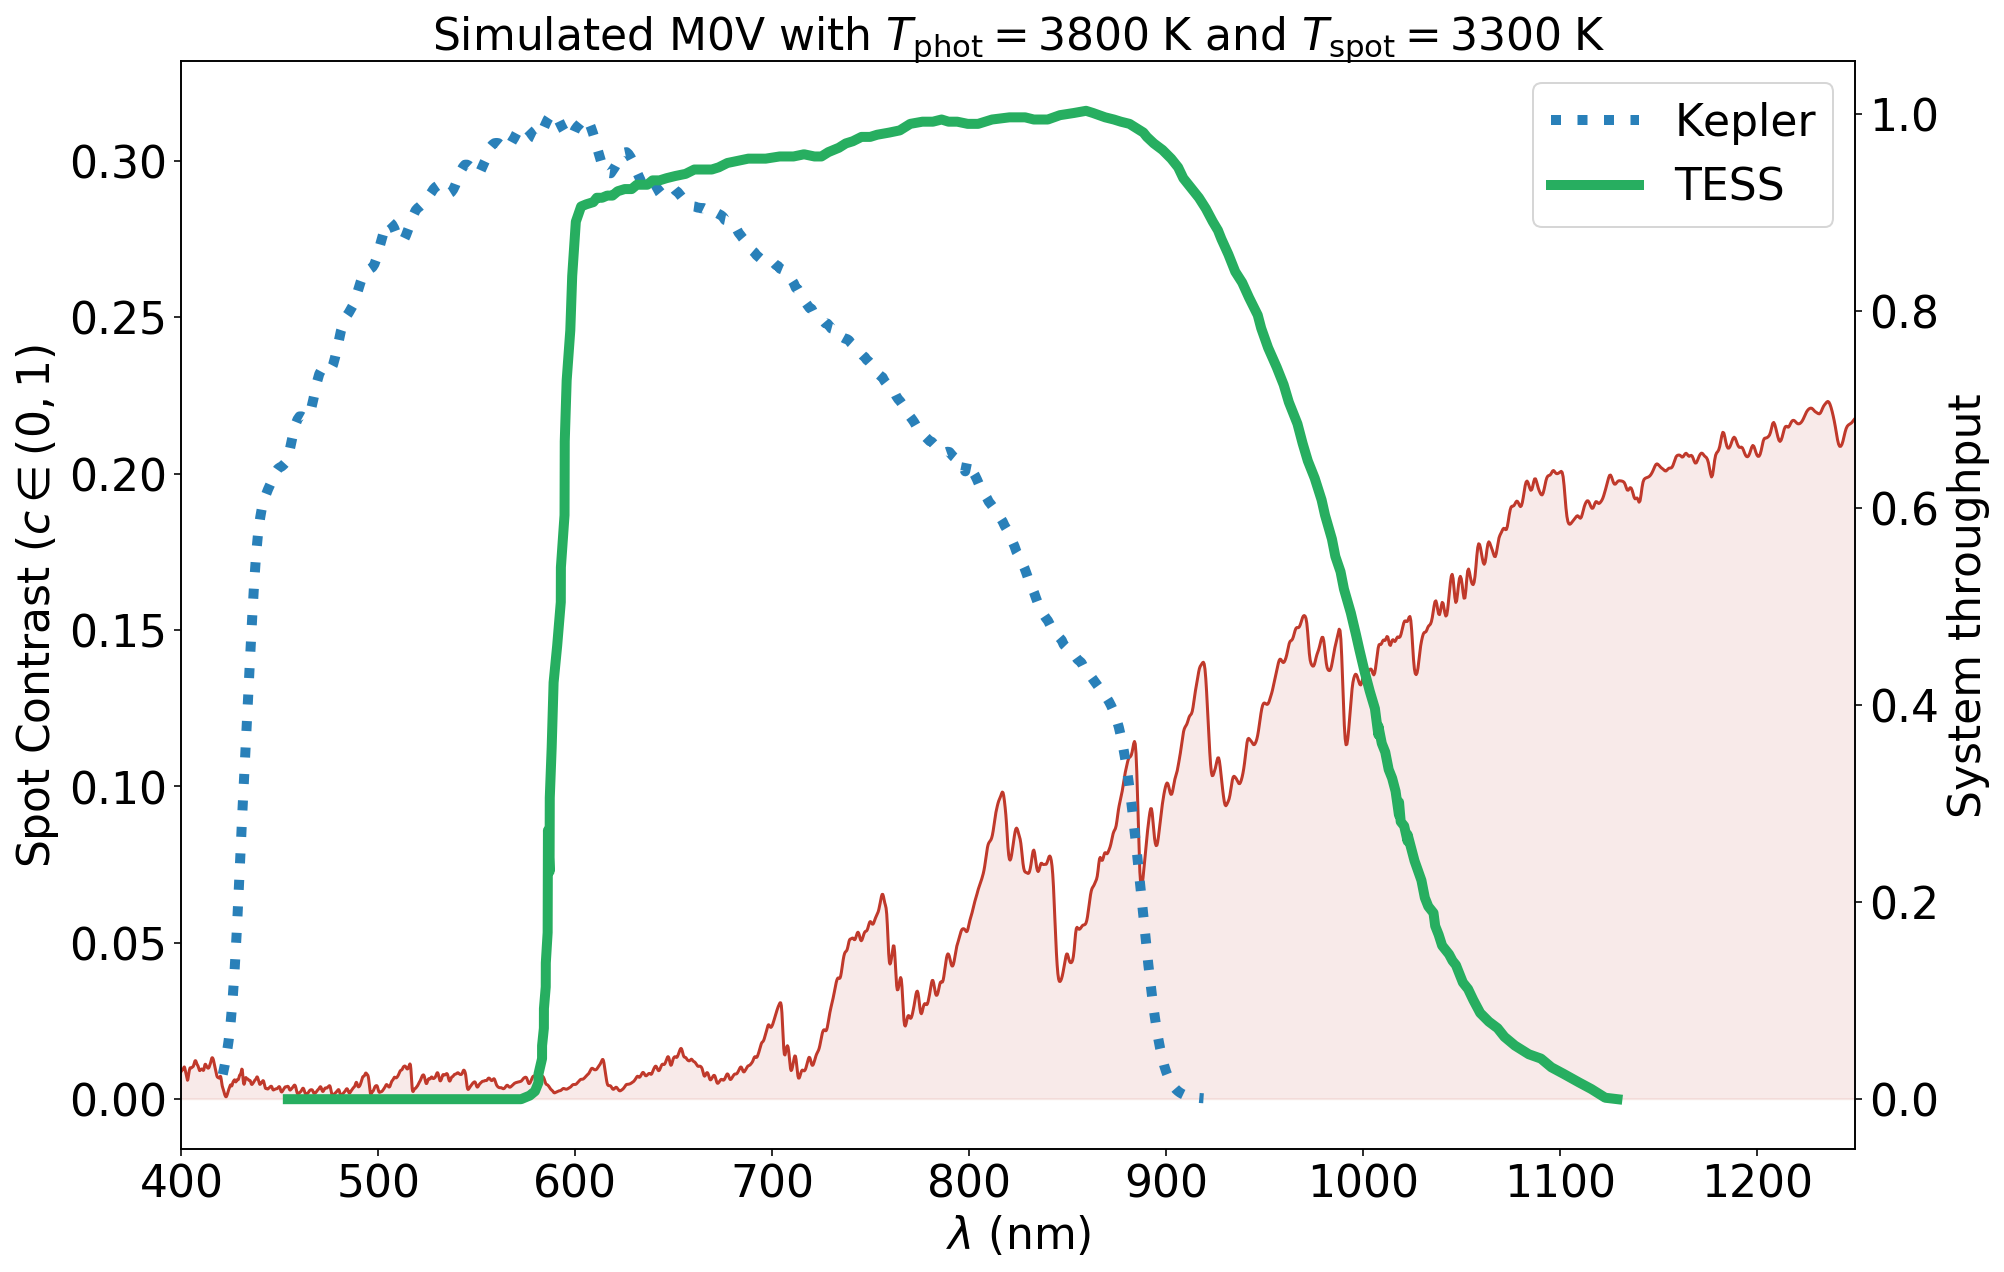

In [36]:
fig, ax = plt.subplots(figsize=(15, 10))
plt.plot(wls_in[:-7]/10.0, contrast_phoenix[:-7], color='#c0392b')
plt.fill_between(wls_in[:-7]/10.0, contrast_phoenix[:-7], 0, color='#c0392b', alpha=0.1)
plt.setp(ax.get_xticklabels(), fontsize=22)
plt.setp(ax.get_yticklabels(), fontsize=22)
plt.ylabel('Spot Contrast $(c\in (0,1)$', fontsize=22)
plt.xlabel('$\lambda$ (nm)', fontsize=22)
plt.title('Simulated M0V with $T_{\mathrm{phot}}=3800\;$K and $T_{\mathrm{spot}}=3300\;$K', fontsize=22)
plt.xlim(400, 1250)


ax2 = ax.twinx()
plt.plot(kep_response.wl_ang/10, kep_response.trans_norm / kep_response.trans_norm.max(), 
         label='Kepler', color='#2980b9', lw=5, linestyle='dotted')
plt.plot(tess_response.wl_nm, tess_response.trans, label='TESS', color='#27ae60', lw=5)
ax2.set_ylabel('System throughput', fontsize=22)
plt.setp(ax2.get_yticklabels(), fontsize=22)
plt.legend(fontsize=22)

plt.savefig('contrast_spectrum2.pdf', bbox_inches='tight')

In [57]:
#map2.show(theta=thetas[0:3])

In [58]:
#np.nanmin(map2.render())

In [131]:
datacube = map2.render()
datacube.shape

(300, 300, 4096)

In [132]:
transit_cube = datacube

In [60]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.animation as animation
import os
%config InlineBackend.figure_format = 'retina'

In [66]:
n_frames = 200
fluxes = map2.flux()
fluxes.shape

(200,)

In [69]:
def animate_flux(res=300, cmap="bone", gif="", interval=75):
    """Animate the map as it rotates."""

    fig, ax = plt.subplots(figsize=(22, 5))

    # the scatter plot:
    
    flx_im, = ax.plot(wls_in, fluxes*0)
    ax.set_ylim(0.99, 1.00)
    ax.set_xlim(3000, 26000)
    plt.yticks([0.99, 0.995, 1.0])
    plt.setp(ax.get_xticklabels(), fontsize=22)
    plt.setp(ax.get_yticklabels(), fontsize=22)
    ax.set_xlabel('$\lambda$ (A)', fontsize=22)
    ax.set_ylabel(' Observed Flux \n ($1 \equiv $ spot free)', fontsize=22)

    # create new axes on the right and on the top of the current axes
    # The first argument of the new_vertical(new_horizontal) method is
    # the height (width) of the axes to be created in inches.
    divider = make_axes_locatable(ax)
    axGlobe = divider.append_axes("left", 5, pad=2.0)

    img = axGlobe.imshow(datacube[:,:, 0], origin="lower", animated=True,
                  interpolation="none", cmap='bone', vmin=0, vmax=0.36)
    axGlobe.axis('off')
    fig.tight_layout()
    

    def updatefig(i):
        img.set_array(datacube[:,:, i])
        flx_im.set_data(wls_in[0:i+1], fluxes[0:i+1])
        return img, flx_im

    ani = animation.FuncAnimation(fig, updatefig, interval=interval,
                                  blit=True,
                                  frames=n_frames-1)#20)

    # Hack to return a gif embedded in HTML if we're
    # inside a Jupyter notebook
    try:
        if 'zmqshell' in str(type(get_ipython())):
            # We're inside a notebook!
            from IPython.display import HTML
            if gif == "":
                if not os.path.exists("_starry"):
                    os.mkdir("_starry")
                gif = os.path.join("_starry", str(id(ani)))
            elif gif.endswith(".gif"):
                gif = gif[:-4]
            ani.save('%s.gif' % gif, writer='imagemagick', dpi=128)
            plt.close()
            print(gif)
            return HTML('<img src="%s.gif">' % gif)
        else:
            raise
    except NameError:
        raise
        #pass

    # Business as usual
    if gif != "":
        if gif.endswith(".gif"):
            gif = gif[:-4]
        ani.save('%s.gif' % gif, writer='imagemagick')
    else:
        plt.show()
    plt.close()

In [70]:
%%time
animate_flux()

_starry/4762640224
CPU times: user 1min 3s, sys: 1.4 s, total: 1min 4s
Wall time: 1min 34s


In [ ]:
plt.plot(fluxes)

In [ ]:
! open _starry/

In [ ]:
! ls -t1 _starry/

In [ ]:
! open _starry/4970028616.gif

In [ ]:
! du -hs _starry/4970028616.gif

In [ ]:
! rm _starry/*.gif